# Evolutionary Algorithm Modules

In [54]:
from evolutionary_computation import *
from env import *
import pickle

In [55]:
with open('results_cartpole-v1/cartpole-v1_solutions_results.pkl', 'rb') as filehandler:
    genome_list = pickle.load(filehandler)

In [56]:
len(genome_list['CartPole-v1'][0][5])

352

In [57]:
env = EAGymEnvWrapper("CartPole-v1")
indiv = Individual(env.get_fitness, env.genome_size)
indiv.genome = genome_list['CartPole-v1'][0][0]
return_value, obs = \
    env.run_gym(indiv.genome)
print(obs)

[[-0.03388908 -0.4363659   0.03489745  0.57724154]
 [-0.0474514  -0.04731986  0.05235735  0.01807156]
 [-0.05326084 -0.43898341  0.05925484  0.63563442]
 ...
 [-0.02848523  0.01716185  0.05128499 -0.00364231]
 [-0.02391175  0.40586764  0.04561787 -0.5558145 ]
 [-0.01159168  0.01453865  0.02951928  0.05424739]]


# DF Construction

In [58]:
import pandas as pd
import numpy as np

In [59]:
df_test = pd.DataFrame(columns = ["Count", "Name"])
df_data = np.unique(np.round(obs, 2), return_counts = True)
df_test["Name"] = df_data[0]
df_test["Count"] = df_data[1]
df_test

,Count,Name
0,1,-2.33
1,1,-2.30
2,1,-2.15
3,1,-2.11
4,2,-1.95
...,...,...
313,1,2.04
314,1,2.08
315,1,2.09
316,1,2.17


# Power Law Modules

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from copy import deepcopy
from IPython.display import display
import re

In [53]:
def power_law_df(df, subject_column = "Name", zipf = True):
    if zipf:
        df_zipf = pd.DataFrame(columns = ["f"])
        df_zipf["f"] = df["Count"].sort_values(ascending = False, ignore_index = True)
        df_zipf.reset_index(names = ["r"], inplace = True)
        df_zipf["r"] += 1
        return df_zipf
    
    else:
        ccdf_df = df.groupby(["Count"]).count()
        ccdf_df.reset_index(inplace = True)
        ccdf_df.rename(columns = {"Count": "k", subject_column: "N_k"}, inplace = True)

        ccdf_df["N_{>= k}"] = pd.Series.empty
        N_k_sum = ccdf_df["N_k"].sum()

        deletion_sum = 0
        ccdf_df.at[0, "N_{>= k}"] = N_k_sum

        for i in range(1, ccdf_df.index.stop):
            deletion_sum += ccdf_df.at[i - 1, "N_k"]
            ccdf_df.at[i, "N_{>= k}"] = N_k_sum - deletion_sum
        return ccdf_df

In [60]:
def power_law_sample_display(df, seed = 0, sample_size = 1000, 
                             zipf = True):
    tag, label = [], []
    if zipf:
        tag = ["r", "f"]
        label = ["Rank", "Frequency"]
    else: # ccdf
        tag = ["k", "N_{>= k}"]
        label = [f"$k$", f"$N_{{>= k}}$"]
    
    np.random.seed(seed)
    sampled_batch = None
    if sample_size != None:
        sampled_batch = np.random.randint(0, df.index.stop, sample_size)
    else:
        sampled_batch = np.arange(df.index.stop)
    df_sample = deepcopy(df.iloc[sampled_batch])
    
    plt.scatter(df_sample[tag[0]], df_sample[tag[1]], 
            5, # markersize
            marker = ".", 
            color = 'b', 
            label = "Sampled Plots")

    plt.xlabel(label[0])
    plt.ylabel(label[1])
    plt.legend()
    plt.show()
    
    #####
    # Log Plot
    #####
    plt.scatter(np.log10(df_sample[tag[0]].astype(float)), 
                np.log10(df_sample[tag[1]].astype(float)), 
            5, # markersize
            marker = ".", 
            color = 'b', 
            label = "Sampled Plots")

    plt.xlabel(f"$\log_{{{10}}}{tag[0]}$")
    plt.ylabel(f"$\log_{{{10}}}{tag[1]}$")
    plt.legend()
    plt.show()
    
    return df_sample

In [61]:
def best_alpha_search(df_sample, zipf = True):
    if zipf:
        tag = ["r", "f"]
    else: # ccdf
        tag = ["k", "N_{>= k}"]
    
    best_alpha = 0
    best_r_squared = 0

    for i in range(1, 101):
        alpha = - 0.01 * i
        results = linregress(df_sample[tag[0]].astype(float) ** alpha, 
                             df_sample[tag[1]].astype(float))

        r_squared_tmp = results.rvalue ** 2
        
        if r_squared_tmp > best_r_squared:
            best_alpha = deepcopy(alpha)
            best_r_squared = deepcopy(r_squared_tmp)

    print("Best Alpha: " + str(round(best_alpha, 3)))
    print("Best R^2: " + str(best_r_squared))
    return best_alpha

In [67]:
def power_law_linear_regression(df_sample, alpha, 
                                zipf = True):
    tag = []
    label = []
    if zipf:
        tag = ["r", "f"]
        label = tag
    else:
        tag = ["k", "N_{>= k}"]
        label = ["k", "N_{{>= k}}"]
        
    X_data = df_sample[tag[0]].astype(float) ** alpha
    y_data = df_sample[tag[1]].astype(float)

    results = linregress(X_data, y_data)

    fig, ax = plt.subplots()

    predictions = results.slope * X_data + results.intercept

    slope_string = str("{:.2e}".format(results.slope))
    intercept_string = str("{:.2e}".format(results.intercept))

    ax.plot(X_data, 
            predictions, 
            label = f"${label[1]} = ({slope_string}) \ {label[0]}^{{{alpha}}} \ $" + \
                f"({intercept_string})", 
            color = 'orange')

    plt.scatter(X_data, y_data, 
                5, # markersize
                marker = ".", 
                color = 'b', 
                label = "Sampled Plots; R^2 = " + str(round(results.rvalue ** 2, 2)))

    plt.xlabel(f"${label[0]}^{{{alpha}}}$")
    plt.ylabel(f"${label[1]}$")
    plt.legend()
    plt.show()
    
    return results

# Power Law Analysis Test

,r,f
0,1,141
1,2,133
2,3,120
3,4,120
4,5,120
...,...,...
313,314,1
314,315,1
315,316,1
316,317,1


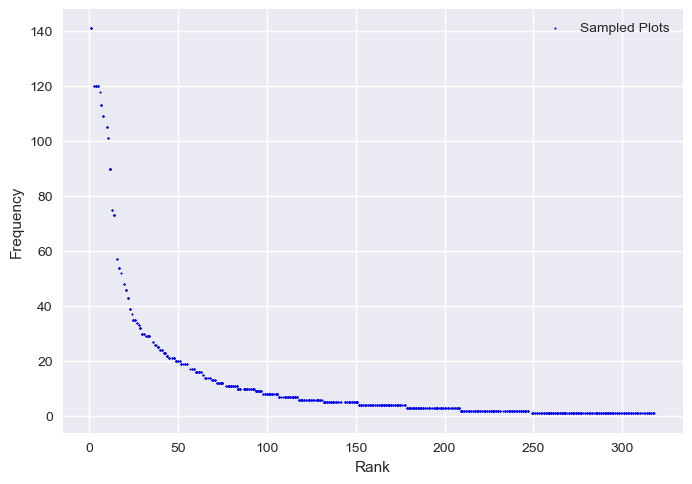

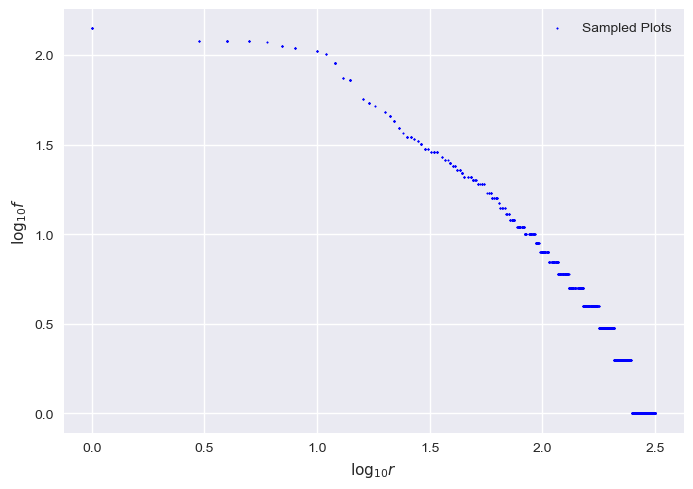

Best Alpha: -0.31
Best R^2: 0.9103408339548813


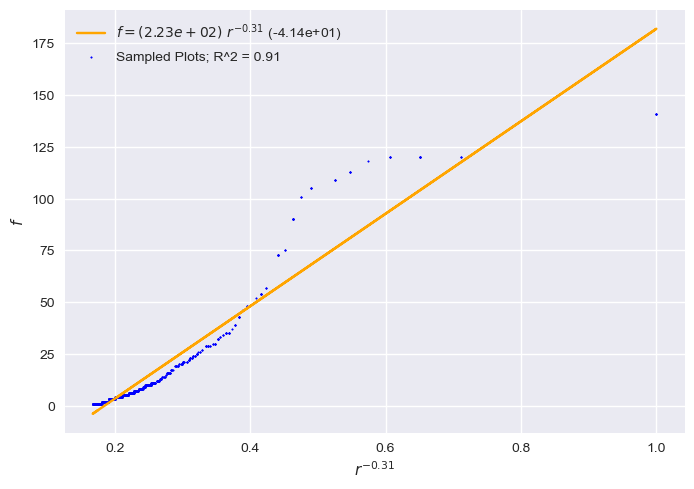

LinregressResult(slope=223.4400526263397, intercept=-41.36418622558471, rvalue=0.9541178302258486, pvalue=0.0, stderr=2.2196836852301747, intercept_stderr=0.5616163473747179)

In [63]:
zipf_df_test = power_law_df(df_test)
display(zipf_df_test)
zipf_df_test_sample = power_law_sample_display(zipf_df_test)
alpha = best_alpha_search(zipf_df_test_sample)
power_law_linear_regression(zipf_df_test_sample, alpha)

,k,N_k,N_{>= k}
0,1,70,318
1,2,40,248
2,3,30,208
3,4,27,178
4,5,20,151
5,6,14,131
6,7,11,117
7,8,9,106
8,9,4,97
9,10,10,93


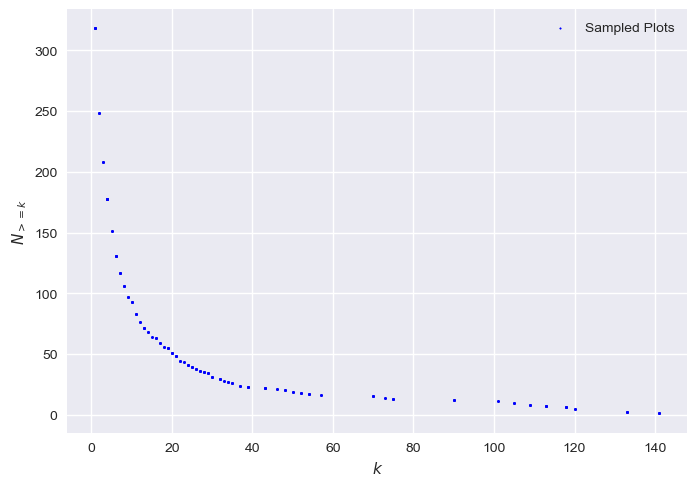

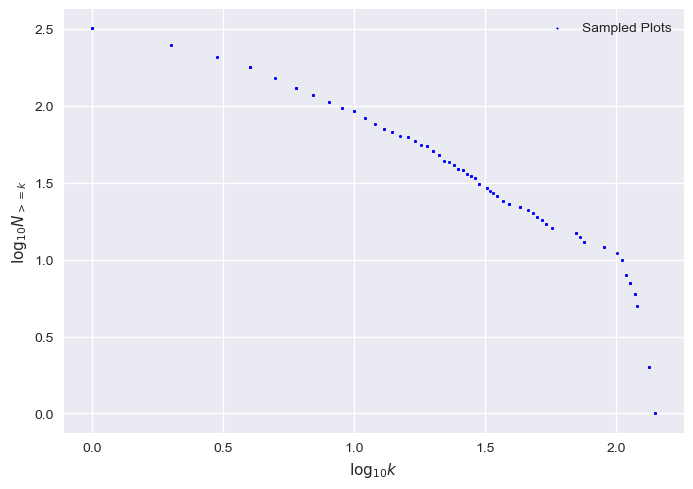

Best Alpha: -0.44
Best R^2: 0.9886567869766736


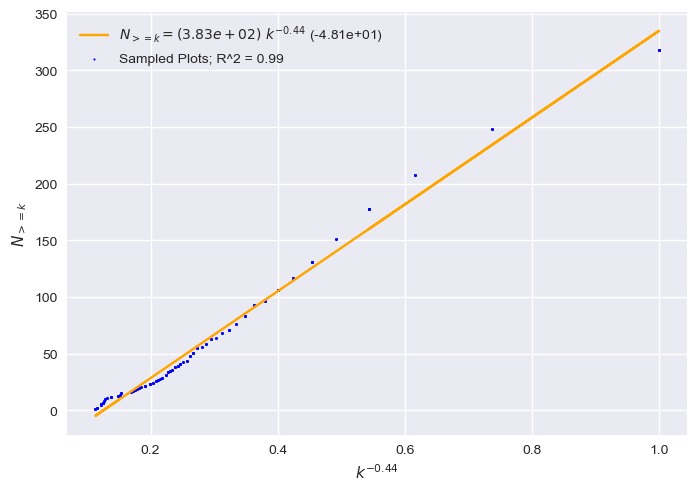

LinregressResult(slope=383.063831841845, intercept=-48.07392713212654, rvalue=0.9943122180566191, pvalue=0.0, stderr=1.2988265151750946, intercept_stderr=0.42333747210445355)

In [68]:
ccdf_df_test = power_law_df(df_test, zipf = False)
display(ccdf_df_test)
ccdf_df_test_sample = power_law_sample_display(ccdf_df_test, zipf = False)
alpha = best_alpha_search(ccdf_df_test_sample, zipf = False)
power_law_linear_regression(ccdf_df_test_sample, alpha, zipf = False)

# Power Law Analysis

In [ ]:
np.random.seed(50)
env = EAGymEnvWrapper("CartPole-v1")
indiv = Individual(env.get_fitness, env.genome_size)
alpha_values = np.empty((len(genome_list['CartPole-v1']), 
                        len(genome_list['CartPole-v1'][0]), 
                        2))
for i in range(len(genome_list['CartPole-v1'])):
    for j in range(len(genome_list['CartPole-v1'][i])):
        print("Run: " + str(i))
        print("Epoch: " + str(j))
        
        #####
        # Dataset Construction
        #####
        indiv.genome = genome_list['CartPole-v1'][i][j]
        return_value, obs = \
            env.run_gym(indiv.genome)

        df_tmp = pd.DataFrame(columns = ["Count", "Name"])
        df_data = np.unique(np.round(obs, 2), return_counts = True)
        df_tmp["Name"] = df_data[0]
        df_tmp["Count"] = df_data[1]

        #####
        # Zipf Analysis
        #####
        zipf_df_tmp = power_law_df(df_tmp)
        zipf_df_tmp_sample = power_law_sample_display(zipf_df_tmp)
        alpha_values[i][j][0] = best_alpha_search(zipf_df_tmp_sample)
        power_law_linear_regression(zipf_df_tmp_sample, alpha_values[i][j][0])

        #####
        # CCDF Analysis
        #####
        ccdf_df_tmp = power_law_df(df_tmp, zipf = False)
        ccdf_df_tmp_sample = power_law_sample_display(ccdf_df_tmp, zipf = False)
        alpha_values[i][j][1] = best_alpha_search(ccdf_df_tmp_sample, zipf = False)
        power_law_linear_regression(ccdf_df_tmp_sample, 
                                    alpha_values[i][j][1], 
                                    zipf = False)

with open('alpha_values.npy', 'wb') as f:
    np.save(f, alpha_values)

In [73]:
with open('alpha_values.npy', 'wb') as f:
    np.save(f, alpha_values)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
with open('alpha_values.npy', 'rb') as f:
    alpha_values = np.load(f)
alpha_values

array([[[-0.28, -0.43],
        [-0.29, -0.45],
        [-0.22, -0.28],
        ...,
        [-0.43, -0.09],
        [-0.35, -0.07],
        [-0.29, -0.16]]])

In [4]:
alpha_values.shape

(1, 1000, 2)

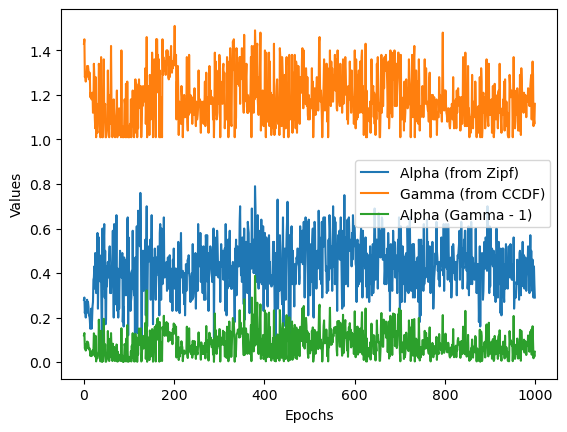

In [12]:
plt.plot(-alpha_values[0, :, 0], label = f"Alpha (from Zipf)")
plt.plot(1 - alpha_values[0, :, 1], label =  f"Gamma (from CCDF)")
plt.plot(alpha_values[0, :, 0] * alpha_values[0, :, 1], 
         label =  f"Alpha (Gamma - 1)")
plt.xlabel("Epochs")
plt.ylabel("Values")
plt.legend()
plt.show()

In [20]:
with open("results_cartpole-v1/cartpole-v1_experiment_results.pkl", 'rb') as filehandler:
    experiment_results = pickle.load(filehandler)
experiment_results["CartPole-v1"][0][:21]

array([ 990.,  990.,  996.,  996.,  996.,  996.,  996.,  996.,  996.,
        996.,  996.,  996.,  996.,  996.,  997.,  997.,  997.,  997.,
        997.,  997., 1000.])

In [21]:
np.max(alpha_values[0, :, 0] * alpha_values[0, :, 1])

0.3871